Импортируем необходимые библиотеки

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
from tqdm.auto import tqdm
from scipy import stats
import requests
from urllib.parse import urlencode
from tqdm.auto import tqdm

import pandahouse as ph

%matplotlib inline 

## A/B–тестирование

Условие:

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод 
A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, 
у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и 
сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

Входные данные

В качестве входных данных Вы имеете 4 csv-файла:    
    
Считаем файлы и запишем их в переменные.

In [5]:
def yandex_data(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    return download_url

In [6]:
groups       =  pd.read_csv(yandex_data('https://disk.yandex.ru/d/UhyYx41rTt3clQ'), sep=';')
checks       =  pd.read_csv(yandex_data('https://disk.yandex.ru/d/pH1q-VqcxXjsVA'), sep=';') 
active_studs =  pd.read_csv(yandex_data('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'), sep=';')
group_add    =  pd.read_csv(yandex_data('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'), sep=',')

Посмотрим на структуру входных данных по первым трем строкам:

In [8]:
groups.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [9]:
checks.head(3)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


In [10]:
active_studs.head(3)

,student_id
0,581585
1,5723133
2,3276743


In [11]:
group_add.head(3)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B


Посмотрим на размер датафреймов

In [13]:
groups.shape

(74484, 2)

In [14]:
checks.shape

(541, 2)

In [15]:
active_studs.shape

(8341, 1)

In [16]:
group_add.shape

(92, 2)

В датафреймах "groups" и "group_add" проверяем:

    
- количество дубликатов; 


- количество пропущенных значений.

In [18]:
duplicate_groups = groups[groups.duplicated(['id'])]
duplicate_groups.shape

(0, 2)

In [19]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [20]:
duplicate_group_add = group_add[group_add.duplicated(['id'])]
duplicate_group_add.shape

(0, 2)

In [21]:
group_add.isna().sum()

id     0
grp    0
dtype: int64

В датафреймах "checks" и  "active_studs" переименуем столбец "student_id" в "id"

In [23]:
checks.rename(columns={'student_id': 'id'}, inplace=True)
active_studs.rename(columns={'student_id': 'id'}, inplace=True)

Проверяем:

- количество повторяющихся значений в "checks"  в колонке "id", по которой будет производиться объединение;

- количество повторяющихся значений в "active_studs"  в колонке "id", по которой будет производиться объединение;

- количество пропущенных значений.

In [25]:
duplicate_checks = checks[checks.duplicated(['id'])]
duplicate_checks.shape

(0, 2)

In [26]:
duplicate_active_studs = active_studs[active_studs.duplicated(['id'])]
duplicate_active_studs.shape

(0, 1)

In [27]:
checks.isna().sum()

id     0
rev    0
dtype: int64

In [28]:
active_studs.isna().sum()

id    0
dtype: int64

Добавляем дополнительные колонки:

In [30]:
group_add['added_later'] = True
active_studs['active_studs'] = True

Объединим датафреймы. Поскольку датафрейм "groups_add" был передан спустя два дня после получения 
основных данных, а о происхождении добавленных пользователей ничего неизвестно, и о периоде проведения эксперимента тоже 
то будем считать, что эти данные собирались из разных источников, но в рамках проведения эксперимента. 
Поэтому включаем пользователей из датафрейма "groups_add" в АБ-тест.

In [32]:
df_all = groups.merge(group_add, how='outer', on=['id', 'grp'])
df_all = df_all.merge(active_studs, how='outer', on=['id'])
df_all = df_all.merge(checks, how='outer', on=['id'])

Заполняем NaN значения значениями по умолчанию:

In [34]:
df_all['added_later'] = df_all.added_later.fillna(False)
df_all['active_studs'] = df_all.active_studs.fillna(False)
df_all['grp'] = df_all.grp.astype('string')

Посмотрим на полученный датафрейм, его вид, размер, уникальные значения по столбцам:

In [36]:
df_all.head()

,id,grp,added_later,active_studs,rev
0,1489,B,False,False,NaN
1,1627,A,False,True,990.0
2,1768,B,False,False,NaN
3,1783,B,False,False,NaN
4,1794,A,False,False,NaN


In [37]:
df_all.shape

(74576, 5)

In [38]:
df_all.grp.unique()

<StringArray>
['B', 'A']
Length: 2, dtype: string

In [39]:
df_all.added_later.unique()

array([False,  True])

In [40]:
df_all.active_studs.unique()

array([False,  True])

In [41]:
df_all.rev.describe()

count     541.000000
mean     1059.752317
std       762.712359
min       199.000000
25%       290.000000
50%       840.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

Посмотрим на распределение по группам в датафрейме "df_all":

In [43]:
df_all.grp.value_counts()/df_all.shape[0] * 100

B    80.297951
A    19.702049
Name: grp, dtype: float64

Проверим обе группы на нормальность распределения:

In [45]:
test_group = df_all.query("grp == 'B'and rev != 'NaN'")
test_group_users = test_group.rev

In [46]:
control_group = df_all.query("grp == 'A' and rev != 'NaN' ")
control_group_users = control_group.rev

In [47]:
stats.normaltest(test_group_users)

NormaltestResult(statistic=33.19587456725772, pvalue=6.18881394639434e-08)

In [48]:
stats.normaltest(control_group_users)

NormaltestResult(statistic=52.21845240353401, pvalue=4.580439316510776e-12)

(array([127., 126.,  29., 135.,   7.,   0.,   7.,   2.,   0.,   1.]),
 array([ 199. ,  644.1, 1089.2, 1534.3, 1979.4, 2424.5, 2869.6, 3314.7,
        3759.8, 4204.9, 4650. ]),
 <a list of 10 Patch objects>)

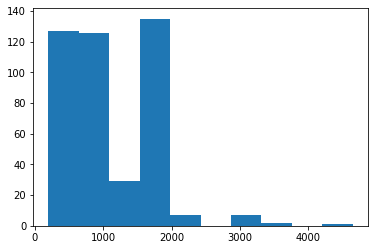

In [49]:
plt.hist(test_group_users)

(array([42., 34., 15.,  3.,  1.,  3.,  0.,  6.,  0.,  3.]),
 array([ 199. ,  545.1,  891.2, 1237.3, 1583.4, 1929.5, 2275.6, 2621.7,
        2967.8, 3313.9, 3660. ]),
 <a list of 10 Patch objects>)

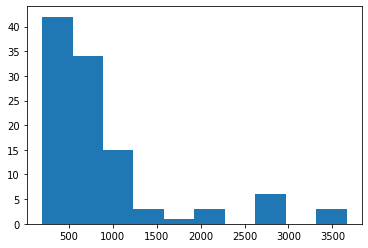

In [50]:
plt.hist(control_group_users)

Группы поделены не равномерно между собой. У группы B явный перекос в бОльшую сторону по количеству пользователей 
(80,2% - группа B, 19.7% группа А).

В обеих группах распределения не являются нормальными, потому что p < 0.05

Посмотрим показатели статистики по группе "А" (контроль, базовая механика):

In [53]:
df_all[df_all.grp == 'A'].describe()

,id,rev
count,1.469300e+04,107.000000
mean,2.170392e+06,860.710280
std,3.220791e+06,815.893445
min,1.627000e+03,199.000000
25%,9.201290e+05,290.000000
50%,1.655923e+06,690.000000
75%,3.320695e+06,990.000000
max,2.002478e+08,3660.000000


Посмотрим показатели статистики по группе "B" (целевая, новая механика):

In [55]:
df_all[df_all.grp == 'B'].describe()

,id,rev
count,5.988300e+04,434.000000
mean,2.164445e+06,1108.824893
std,2.669793e+06,741.834304
min,1.489000e+03,199.000000
25%,9.196960e+05,420.750000
50%,1.676292e+06,935.000000
75%,3.328984e+06,1900.000000
max,2.010677e+08,4650.000000


Построим боксплот распределения покупок по группам среди всех пользователей:

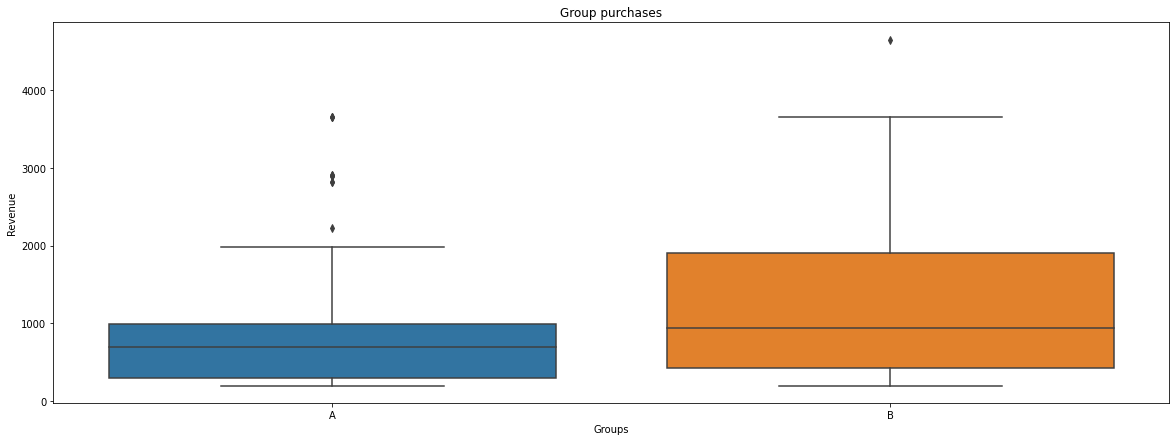

In [57]:
plt.figure(figsize=(20, 7))
sns.boxplot(x='grp', y='rev', data=df_all.query("rev!=0 and rev !='NaN'"))
plt.xlabel('Groups')
plt.ylabel('Revenue')
plt.title("Group purchases")
plt.show()

Посмотрим на распределение оплат с помощью графика "histplot":

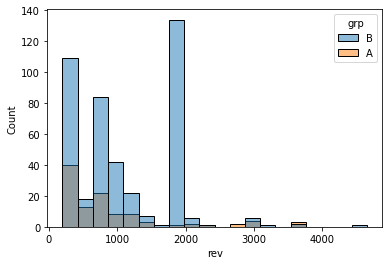

In [59]:
sns.histplot(data=df_all, x="rev", hue='grp', bins=20)

Распределения оплат выглядят явно не равномерными, не унимодальными, имеют выбросы.

Из графиков боксплот мы видим, что в наших данных есть выбросы, значит применение Т-критерия 
будет не правильным (Т-критерий сравнивает средние в распределениях, а выбросы сильно влияют на значение среднего).

Также из-за выбросов сравнение средних в наших выборках будет не корректно.

Посмотрим на распределения покупкак среди покупающих пользователей (датафрейм "checks"):

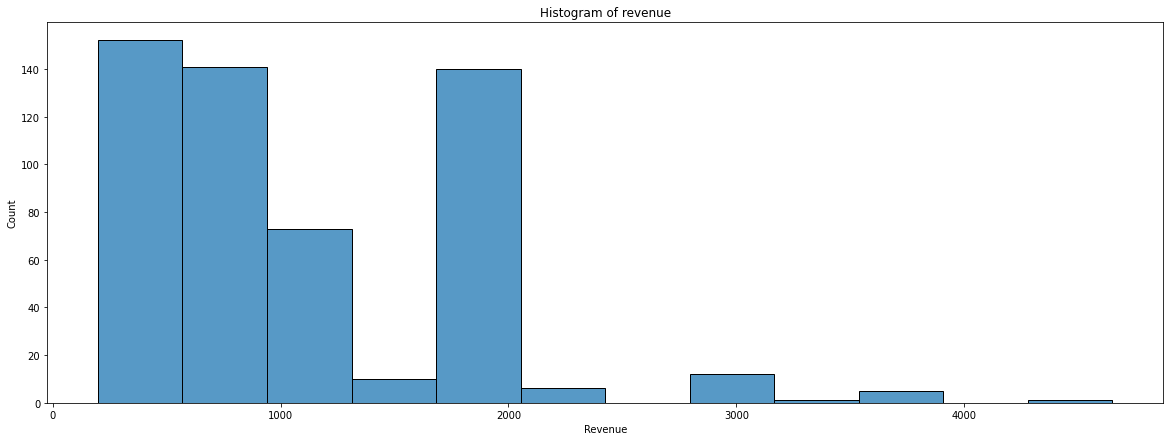

In [62]:
plt.figure(figsize=(20, 7))
sns.histplot(x='rev', data=checks)
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.title("Histogram of revenue")
plt.show()

Из графиков видно, что распределения далеки от нормальных, а значит применение Т-теста недопустимо.
В данной ситуации считаем оптимальным применение методом Бутсрапа.

Проверяемые гипотезы:
## H0 - средний чек и ARPU одинаковые в обеих группах
## H1 - средний чек и ARPU отличаются в обеих группах

Отфильтруем пользователей для АБ-теста.

Нам нужны пользователи:

1. которые заходили в приложение во время эксперимента.

2. которые совершали оплату во время эксперимента.

In [66]:
AB_test_df = df_all.query('active_studs == True or rev.notna()')
AB_test_df.head(3)

,id,grp,added_later,active_studs,rev
1,1627,A,False,True,990.0
10,2085,B,False,True,NaN
12,2215,B,False,True,NaN


Посмотрим на размер полученного датафрейма "AB_test_df":

In [68]:
AB_test_df.shape

(8490, 5)

Посмотрим на распределение оплат с помощью гистограммы:

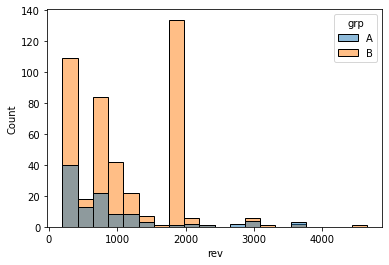

In [70]:
sns.histplot(data=AB_test_df, x="rev", hue='grp', bins=20)

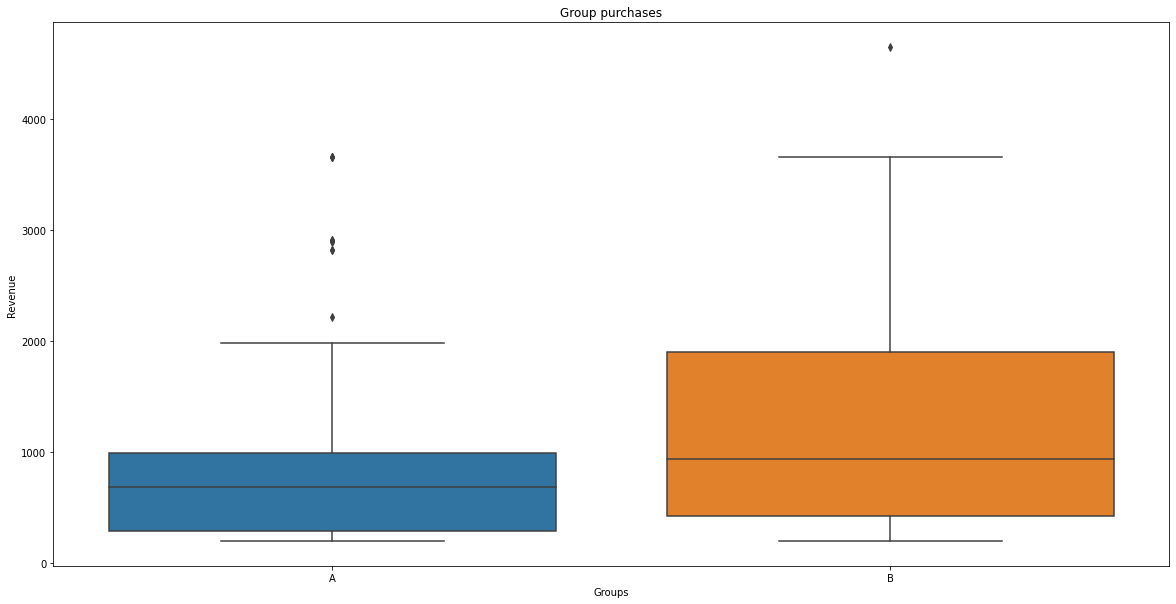

In [71]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='grp', y='rev', data=AB_test_df)
plt.xlabel('Groups')
plt.ylabel('Revenue')
plt.title("Group purchases")
plt.show()

Посмотрим на метрики:

In [73]:
metrics = pd.DataFrame()
metrics['CR_to_clients'] = AB_test_df.groupby('grp').rev.count() / AB_test_df.groupby('grp').id.count()
metrics['mean_revenue'] = AB_test_df.groupby('grp').rev.mean()
metrics['repeat_purchases'] = AB_test_df.groupby('grp').rev.count() / AB_test_df.query('rev.notna()').groupby('grp').rev.count()
metrics['arppu'] = metrics['repeat_purchases'] * AB_test_df.groupby('grp').rev.mean()
metrics['arpu'] = metrics['CR_to_clients']*metrics['arppu']
metrics

,CR_to_clients,mean_revenue,repeat_purchases,arppu,arpu
A,0.068283,860.710280,1.0,860.710280,58.772176
B,0.062690,1108.824893,1.0,1108.824893,69.511773


Конверсия в покупателя у группы А выше, чем у группы Б. Не исключено, что причина в том, что группа А 
меньше по к-ву пользователей, чем группа Б.

Для теста выберем две метрики - это средний чек и ARPU. Проведем бутстрап тесты по этим метрикам и посмотрим на результаты.

Для корректного проведения теста по среднему чеку в бутстрапе мы будем игнорировать значения NaN. 

Для подсчета ARPU выделена отдельная функция, чтобы ARPU считалось по подвыборкам.

In [75]:
def get_bootstrap(
    dataframe_1, # датафрейм первой выборки
    dataframe_2, # датафрейм второй выборки
    col_1, # название колонки первой выборки
    col_2, # название колонки второй выборки
    sample_count_1 = 0, # количество наблюдений для подвыборок
    sample_count_2 = 0, # количество наблюдений для подвыборок
    boot_it = 10000, # количество бутстрэп-подвыборок
    statistic = 'mean', # интересующая нас статистика(среднее значение)
    conf_level = 0.95, # уровень значимости
    replace = True, # параметр возвращения
    max_len = True
):

    if sample_count_1 == 0:
        sample_count_1 = len(dataframe_1[col_1])
    
    if sample_count_2 == 0:
        sample_count_2 = len(dataframe_2[col_2])
    if max_len:
        bootstrap_len = max([sample_count_1, sample_count_2])
    else:
        bootstrap_len = min([sample_count_1, sample_count_2])
    
    bootstrap_data = []
    smpl_1_data = []
    smpl_2_data = []
    for i in tqdm(range(boot_it)): 
        if statistic == 'arpu':
            samples_1 = arpu(dataframe_1.sample(bootstrap_len, replace=replace))
            samples_2 = arpu(dataframe_2.sample(bootstrap_len, replace=replace))            
        else:
            samples_1 = np.nanmean(dataframe_1[col_1].sample(bootstrap_len, replace=replace).values)
            samples_2 = np.nanmean(dataframe_2[col_2].sample(bootstrap_len, replace=replace).values)
        
        
        bootstrap_data.append(samples_1-samples_2)
        smpl_1_data.append(samples_1)
        smpl_2_data.append(samples_2)
        
    pd_bootstrap_data = pd.DataFrame(bootstrap_data)
        
    left_quant = (1 - conf_level)/2
    right_quant = 1 - (1 - conf_level) / 2
    quants = pd_bootstrap_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.nanmean(bootstrap_data), 
        scale = np.nanstd(bootstrap_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.nanmean(bootstrap_data), 
        scale = np.nanstd(bootstrap_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_bootstrap_data[0], bins = 30)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('blue')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('bootstrap_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    
    print('pvalue = ', p_value)
       
    return {"bootstrap_data" : bootstrap_data, 
            "quants" : quants, 
            "p_value" : p_value,
           "smpl_1_data" : smpl_1_data,
           "smpl_2_data" : smpl_2_data}

In [76]:
def arpu(df):
    repeat_purchases = df.rev.count() / df.query('rev.notna()').rev.count()
    arppu = repeat_purchases * df.rev.mean()
    return (df.rev.count() / df.id.count())*arppu

Применим бутстрап к среднему чеку, max_len = False

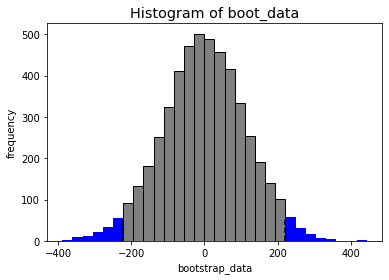

pvalue =  0.9987010211498076


In [78]:
bootstraped_data = get_bootstrap(dataframe_1 = AB_test_df [AB_test_df.grp == "A"], col_1 = 'rev',
                                 dataframe_2 = AB_test_df [AB_test_df.grp == "A"], col_2 = 'rev',
                                 boot_it = 5000,
                                 statistic = 'mean',
                                 max_len = False)

На графике (bootstraped_data) видно, что распределения разниц между средними немного пересекают отметку 0. 

То есть очень малое количество наблюдений из двух выборок пересекаются между собой.

pvalue < уровня значимости 0.05. Это дает нам основания ОТВЕРГНУТЬ нулевую гипотезу о том, что 
новая механика оплаты услуг на сайте в группе B не отличается от старой механики, оставленной в группе A.

Применим метод Бутстрап по arpu, max_len = False

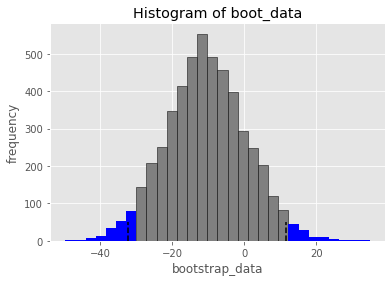

pvalue =  0.3447297313783054


In [81]:
bootstraped_data_arpu = get_bootstrap(dataframe_1 = AB_test_df [AB_test_df.grp == "A"], col_1 = 'rev',
                                      dataframe_2 = AB_test_df [AB_test_df.grp == "B"], col_2 = 'rev',
                                      boot_it = 5000, 
                                      statistic = 'arpu',
                                      max_len = False)

В соответствии с графиком, при сравнении распределений ARPU pvalue превысил уровень значимости в 0.05, 
что не позволяет отвергнуть нулевую гипотезу. Вероятноть того, что среднее значение ARPU группы Б 
примет среднее значение ARPU группы А достаточно велика.

Ниже приведен график распределения разниц ARPU:

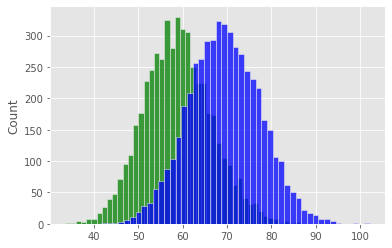

In [84]:
sns.histplot(bootstraped_data_arpu['smpl_1_data'], color='g')
sns.histplot(bootstraped_data_arpu['smpl_2_data'], color='b')

По графику видно, что в большинстве наблюдений ARPU в группе Б все таки выше, чем в группе А.

При импользовании метода "bootstrap" выше максимальное количество наблюдений бралось по количеству записей в группе А. 
Применим еще раз  бутстрап тест, но по максимальному количеству наблюдений по группе Б.

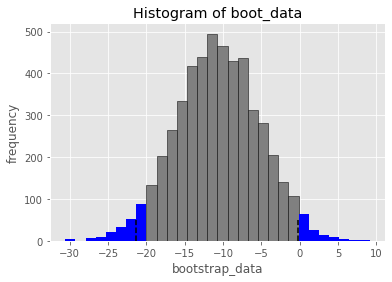

pvalue =  0.04841699482431633


In [87]:
booted_data_max_B = get_bootstrap(dataframe_1 = AB_test_df [AB_test_df.grp == "A"], col_1 = 'rev',
                                  dataframe_2 = AB_test_df [AB_test_df.grp == "B"], col_2 = 'rev',
                                  boot_it = 5000,
                                  statistic = 'arpu',
                                  max_len = True)

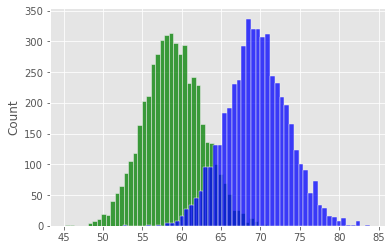

In [88]:
sns.histplot(booted_data_max_B['smpl_1_data'], color='g')
sns.histplot(booted_data_max_B['smpl_2_data'], color='b')

Поскольку в группе Б больше уникальных записей по сравнению с группой А, то различия 
более явно прослеживаются. pvalue не превысил уровень значимости в 0.05

Выводы по АБ-тесту.
Основные гипотезы:
    
H0 - средний чек и ARPU одинаковые в обеих группах;

H1 - средний чек и ARPU отличаются в обеих группах.

По Бутстрапу по среднему чеку  pvalue < 0.05, что  отвергнуть нулевую гипотезу.
Бутстрап по ARPU и количеству наблюдений в подвыборках равному 1567 (по группе А) наблюдений показал pvalue > 0.05. 

Данный результат не дает основания отвергнуть нулевую гипотезу.
Бутстрап по ARPU и количеству наблюдений в подвыборках равному 6923 (по группе Б) наблюдений показал pvalue < 0.05. 

Результат позволяет отвергнуть нулевую гипотезу.

Рассмотрев разницу распределений метрик наглядно выявлено явное различие между группами, где показатели распределений 
в группе Б лучше, чем в группе А во всех тестах.

Поэтому имеет смысл применить новую механику оплаты услуг на всех пользователей. 

Однако для более точного проведения АБ-тестирования нужно было выделить больше пользователей для группы А, 
потому что из-за малого количества уникальных пользователей в группе А может возникнуть ситуация, в которой тесты показали
значимые различия, а в генеральной совокупности различий на самом деле нет.